In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import PredefinedSplit
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
from model_pipeline import get_train_test, MissingValueTransformer, \
    CreateFeaturesTransformer, searcher_builder, data_formatted, \
    get_metrics
from models import TorchRegressor

In [3]:
# Constants
RANDOM_STATE = 42
VALIDATION_PORTION = 0.2
FEATURES = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
            'PT08.S5(O3)', 'T', 'RH', 'AH']
TARGET = ['NMHC(GT)', 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
TARGET_ENOUGH=['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

In [4]:
# Global
metrics_all = {}
train_dataset, test_dataset = get_train_test()
train_dataset_NMHC, test_dataset_NMHC = get_train_test(if_NMHC=True)

In [5]:
# run this cell above

In [19]:
short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    for target in TARGET:
        print(f"Processing target: {target}")
        X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
            train_dataset, test_dataset, target, params=features_config
        ) if target != 'NMHC(GT)' else data_formatted(
            train_dataset_NMHC, test_dataset_NMHC, target, params=features_config
        )

        model = TorchRegressor()

        hyperspace = {
            "model__lr": Real(1e-6, 1e-1, prior="log-uniform"),
            "model__hidden": Integer(128, 256),
            "model__epochs": Categorical([60]),
            "model__dropout": Real(0.1, 0.3)
        }

        nn_opt = searcher_builder(hyperspace, model, X_train.shape[0])
        nn_opt.fit(X_train, Y_train)
        pickle.dump(nn_opt, open(f'regression_searchers/reg_nn_{target}_{feature_set_name}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)
Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [20]:
from sklearn.linear_model import LinearRegression
short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    for target in TARGET:
        print(f"Processing target: {target}")
        X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
            train_dataset, test_dataset, target, params=features_config
        ) if target != 'NMHC(GT)' else data_formatted(
            train_dataset_NMHC, test_dataset_NMHC, target, params=features_config
        )

        model = LinearRegression()

        hyperspace = {
            "model__fit_intercept": Categorical([True]),
        }

        nn_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
        nn_opt.fit(X_train, Y_train)
        pickle.dump(nn_opt, open(f'regression_searchers/reg_linear_{target}_{feature_set_name}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)
Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [ ]:
from sklearn.linear_model import LinearRegression
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
for target in TARGET:

    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=long_features
    ) if target != 'NMHC(GT)' else data_formatted(
        train_dataset_NMHC, test_dataset_NMHC, target, params=long_features
    )

    model = LinearRegression()

    hyperspace = {
    "model__fit_intercept": Categorical([True]),
    }

    nn_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
    nn_opt.fit(X_train, Y_train)
    pickle.dump(nn_opt, open(f'regression_searchers/reg_linear_{target}_long.pkl', 'wb'))

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [10]:
train_dataset, test_dataset = get_train_test(if_NMHC=True)

In [ ]:
train_dataset, test_dataset = get_train_test(if_NMHC=True)
X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
    train_dataset, test_dataset, 'NMHC(GT)', params={'lags': [1,3,6,12,24], 'window_sizes': [3,6,12]}
)

model = LinearRegression()

hyperspace = {
    "model__fit_intercept": Categorical([True]),
}

linear_regression_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
linear_regression_opt.fit(X_train, Y_train)
pickle.dump(linear_regression_opt, open('regression_searchers/reg_linear_nmhc_short.pkl', 'wb'))

# Evaluation

In [8]:
metrics_all = {}

folder = "./regression_searchers"   # 你的文件夹

feature_sets = {
    'short': {'lags': [1,3,6,12,24], 'window_sizes': [3,6]},
    'long': {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
} 

def load_opt_from_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

for filename in os.listdir(folder):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder, filename)

    # ------- 1. 加载 opt -------
    opt = load_opt_from_pkl(file_path)

    # ------- 2. 从文件名提取目标列名 eg. CO(GT) -------
    # 文件名格式：
    #    reg_linear_CO(GT)_long.pkl
    #    reg_nn_NOx(GT)_short.pkl
    # => 我们取第三段（split("_")[2]）
    try:
        name_parts = filename.replace(".pkl", "").split("_")
        target_column = name_parts[2]     # eg. CO(GT)
        feature_set = name_parts[3]     # eg. long / short
    except:
        print(f"[WARN] 文件名格式无法解析：{filename}")
        continue

    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target_column, feature_sets[feature_set]
    ) if target_column != 'NMHC(GT)' else data_formatted(
        train_dataset_NMHC, test_dataset_NMHC, target_column, feature_sets[feature_set]
    )
    metrics = get_metrics(opt, 
                        X_test, Y_test, Y_baseline, scaler_Y, target_column)
    key = filename.replace(".pkl", "")
    metrics_all[key] = metrics

In [9]:
metrics_all.keys()

dict_keys(['reg_linear_C6H6(GT)_long', 'reg_linear_C6H6(GT)_short', 'reg_linear_CO(GT)_long', 'reg_linear_CO(GT)_short', 'reg_linear_NMHC(GT)_long', 'reg_linear_NMHC(GT)_short', 'reg_linear_NO2(GT)_long', 'reg_linear_NO2(GT)_short', 'reg_linear_NOx(GT)_long', 'reg_linear_NOx(GT)_short', 'reg_nn_C6H6(GT)_long', 'reg_nn_C6H6(GT)_short', 'reg_nn_CO(GT)_long', 'reg_nn_CO(GT)_short', 'reg_nn_NMHC(GT)_long', 'reg_nn_NMHC(GT)_short', 'reg_nn_NO2(GT)_long', 'reg_nn_NO2(GT)_short', 'reg_nn_NOx(GT)_long', 'reg_nn_NOx(GT)_short'])

In [13]:
def rmse_tables_split(metrics_all):
    grouped = {}

    for model_name, m in metrics_all.items():
        col = m["column"]
        if col not in grouped:
            grouped[col] = []
        grouped[col].append({"model": model_name, "rmse": m["rmse"]})

    # 转为表格
    tables = {}
    for col, rows in grouped.items():
        df = pd.DataFrame(rows).sort_values("rmse")
        tables[col] = df

    return tables

tables = rmse_tables_split(metrics_all)

# 展示
for variable, df in tables.items():
    print(f"\n===== {variable} =====")
    print(df)


===== C6H6(GT) =====
                       model      rmse
2       reg_nn_C6H6(GT)_long  4.723169
0   reg_linear_C6H6(GT)_long  4.761507
3      reg_nn_C6H6(GT)_short  4.926461
1  reg_linear_C6H6(GT)_short  4.948642

===== CO(GT) =====
                     model      rmse
0   reg_linear_CO(GT)_long  1.087988
2       reg_nn_CO(GT)_long  1.118193
1  reg_linear_CO(GT)_short  1.121760
3      reg_nn_CO(GT)_short  1.147013

===== NMHC(GT) =====
                       model        rmse
3      reg_nn_NMHC(GT)_short  152.744316
2       reg_nn_NMHC(GT)_long  154.372288
1  reg_linear_NMHC(GT)_short  168.167856
0   reg_linear_NMHC(GT)_long  175.555386

===== NO2(GT) =====
                      model       rmse
0   reg_linear_NO2(GT)_long  47.581961
1  reg_linear_NO2(GT)_short  47.980253
3      reg_nn_NO2(GT)_short  48.952259
2       reg_nn_NO2(GT)_long  49.601487

===== NOx(GT) =====
                      model        rmse
1  reg_linear_NOx(GT)_short  178.730325
0   reg_linear_NOx(GT)_long  180.9

In [27]:
import pandas as pd

def rmse_and_improvement_table(metrics_all):
    rows = []
    for model_name, m in metrics_all.items():
        rmse = m["rmse"]
        improvements = m["improvement_over_baseline_percentage"]
        var = m["column"]

        # improvements 是数组 → 每个 index 对应一行
        for i, imp in enumerate(improvements):
            rows.append({
                "target_column": var,
                "model": model_name,
                "time_horizon": f"_{['01','06','12','24'][i]}h",
                "rmse": rmse,
                "improvement_%": imp
            })

    df = pd.DataFrame(rows)
    df = df.sort_values(["target_column", "time_horizon","model"])
    return df

rmse_imp_df = rmse_and_improvement_table(metrics_all)
rmse_imp_df.to_csv("./metrics/rmse_and_improvement_all_models.csv", index=False)


In [6]:
from metrics_plot import plot_training_loss_curve, plot_predicted_vs_actual

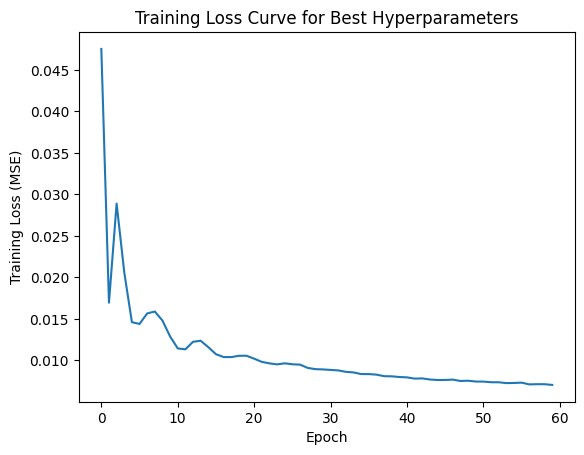

In [7]:
plot_training_loss_curve(metrics_all['neural_network'])

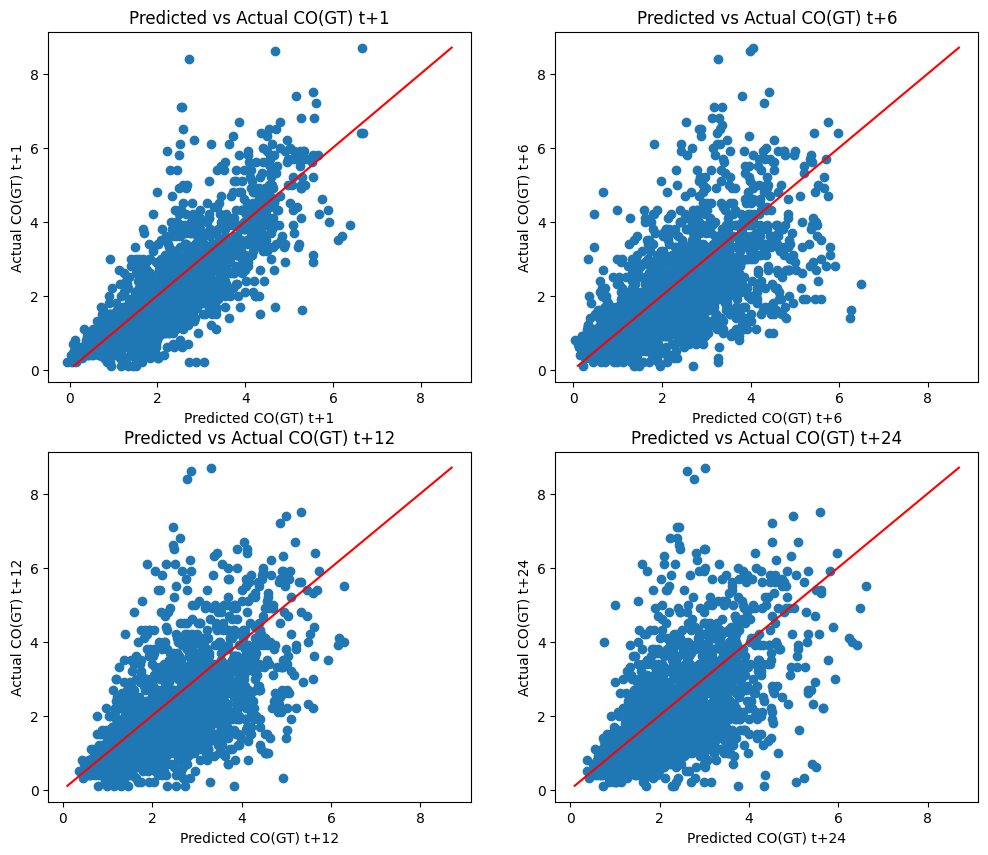

In [8]:
plot_predicted_vs_actual(metrics_all['neural_network'])